<a href="https://colab.research.google.com/github/fjadidi2001/Artificial_Intelligence_Learning/blob/master/olympic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import the necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt # These classes are used for implementing different types of exponential smoothing models for forecasting time series data.
from datetime import datetime, timedelta

# import the data set
data = pd.read_csv('swimming.csv')

# drop NA values(missing values) and reset the index
data = data.dropna()
data = data[data['Rank'] != 0] # disqualified, did not start, did not finish => rank = 0
data = data.reset_index(drop = True)

# format the results string to get all times in the same format
for i in range(len(data)):
    item = data.iloc[i,8]
    if item.count('.') == 0:
        data.iloc[i,8] = item+'.00'

for i in range(len(data)):
    item = data.iloc[i,8].split('.')[0] + '.' + data.iloc[i,8].split('.')[1]
    if item.count(':')==0:
        data.iloc[i,8]='00:00:'+item
    elif item.count(':')==1:
        data.iloc[i,8]='00:'+item
    elif item.count(':')==2:
        data.iloc[i,8]=item
'''

1. `for i in range(len(data)):`
   - This line sets up a loop that will iterate over each row in the dataset `data`. The variable `i` will take on values from 0 to the length of the dataset minus 1.

2. `item = data.iloc[i,8]`
   - This line retrieves the value in the 8th column of the `i`-th row of the dataset `data` and stores it in a variable called `item`.

3. `if item.count('.') == 0:`
   - This line checks if the variable `item` contains zero occurrences of the character '.'.

4. `data.iloc[i,8] = item+'.00'`
   - If the condition in the previous line is met, this line appends '.00' to the end of the value in the 8th column of the `i`-th row of the dataset `data`.

5. The second `for` loop does the following:
   - It iterates over each row in the dataset `data` again.

6. `item = data.iloc[i,8].split('.')[0] + '.' + data.iloc[i,8].split('.')[1]`
   - This line splits the value in the 8th column of the `i`-th row of the dataset `data` by the '.' character and then reconstructs it with a '.' between the two parts.

7. The following `if` statements check how many ':' characters are present in the `item`:
   - `if item.count(':')==0:`: If there are no ':' characters, it adds '00:00:' to the beginning of the value.
   - `elif item.count(':')==1:`: If there is one ':' character, it adds '00:' to the beginning of the value.
   - `elif item.count(':')==2:`: If there are two ':' characters, it keeps the value as it is.

8. The corresponding `data.iloc[i,8] = ...` lines update the value in the 8th column of the `i`-th row of the dataset `data` based on the conditions met in the previous steps.
'''
# remove rows not formatted correctly
data = data[~data['Results'].str.contains('est')]

#create the date time columns
data['Date_Time'] = pd.to_datetime(data['Results'], format='%H:%M:%S.%f')
data['Time'] = data['Date_Time'].dt.time


for i in range(len(data)):
    data.iloc[i,11] = data.iloc[i,11].minute * 60 + data.iloc[i,11].second

data['Time'] = data['Time'].astype(str)
data['Final_Time'] = [None] * len(data)

#convert all of the times into seconds and milliseconds
for i in range(len(data)):
    if data.iloc[i,1] == 2020:
        ms = data.iloc[i,8].split('.')[1]
        ms = float(ms)
        ms = ms/100
        ms = str(ms)
        ms = ms.split('.')[1]
        data.iloc[i,12] = data.iloc[i,11] + '.' + ms
    else:
        string = data.iloc[i,8].split('.')[1]
        if len(string) == 3:
            ms = float(string)
            ms = ms/1000
            ms = str(ms)
            ms = ms.split('.')[1]
            data.iloc[i,12] = data.iloc[i,11] + '.' + ms
        if len(string) == 6:
            ms = float(string)
            ms = ms/1000000
            ms = str(ms)
            ms = ms.split('.')[1]
            data.iloc[i,12] = data.iloc[i,11] + '.' + ms

#change the final time to a numeric
data['Final_Time'] = data['Final_Time'].astype(float)

#get separate data frame for the gold medalists
gold = data[data['Rank'] == 1]

#create a function to format the data correctly
def event(gender, distance, stroke):
    name = gold[(gold["Gender"] == gender) & (gold['Distance (in meters)'] == distance) & (gold['Stroke'] == stroke)]
    name = name.sort_values(by = 'Year')
    name = name[['Year', 'Date_Time', 'Final_Time']]

    # Check for duplicates and remove them
    column_to_check = 'Final_Time'
    duplicates_mask = name[column_to_check].duplicated()
    if any(duplicates_mask):
        name = name[~duplicates_mask].copy() #keep first occurance and remove the rest

    name = name.reset_index(drop = True)
    name = name[name['Year'] >= 1948]
    name = name[name['Year'] <= 2016]
    return name

#create a function to execute the modeling (and one for damped model)
def model(race):
    #convert the year column to a date-time
    for i in range(len(race)):
        year = race.iloc[i,0]
        date = datetime(year,12,31).date()
        race.iloc[i,0] = date

    #format the data correctly for the model
    race = race.drop('Date_Time', axis = 1)
    race['Year'] = pd.to_datetime(race['Year'])
    race = race.set_index('Year')

    #execute the model
    model = ExponentialSmoothing(race['Final_Time'], trend='add', seasonal=None, damped_trend = False, freq='4A')
    results = model.fit()
    results.summary()
    fcast = results.forecast(1)

    return fcast

def model2(race):
    #convert the year column to a date-time
    for i in range(len(race)):
        year = race.iloc[i,0]
        date = datetime(year,12,31).date()
        race.iloc[i,0] = date

    #format the data correctly for the model
    race = race.drop('Date_Time', axis = 1)
    race['Year'] = pd.to_datetime(race['Year'])
    race = race.set_index('Year')

    #execute the model
    model = ExponentialSmoothing(race['Final_Time'], trend='add', seasonal=None, damped_trend = True, freq='4A')
    results = model.fit()
    results.summary()
    fcast = results.forecast(1)

    return fcast
#%% #apply the functions to the different events
m50free = event('Men', '50m', 'Freestyle') #9 *only introduced in 1988
w50free = event('Women', '50m', 'Freestyle') #9

m100free = event('Men','100m','Freestyle') #19
w100free = event('Women','100m','Freestyle') #18 (missing 1952)

#add missing row for women's 100 free
newrow = {'Year': 1952, 'Date_Time': pd.to_datetime('00:01:06.80', format='%H:%M:%S.%f'), 'Final_Time': 66.80}
w100free = w100free.reset_index(drop = True)
w100free.loc[len(w100free)] = newrow
w100free = w100free.sort_values(by = 'Year')
w100free = w100free.reset_index(drop = True)

m200free = event('Men','200m','Freestyle') #14
w200free = event('Women','200m','Freestyle') #14

m400free = event('Men','400m','Freestyle') #19
w400free = event('Women','400m','Freestyle') #19

m800free = event('Men','800m','Freestyle') #1
w800free = event('Women','800m','Freestyle') #14 *introduced in 1968

m1500free = event('Men','1500m','Freestyle') #19
w1500free = event('Women','1500m','Freestyle') #1

m100bk = event('Men','100m','Backstroke') #18 (missing 1964)
w100bk = event('Women','100m','Backstroke') #19

#add missing row for men's 100 back - the event was actually removed this year, so average time used
newrow = {'Year': 1964, 'Date_Time': pd.to_datetime('00:01:01.05', format='%H:%M:%S.%f'), 'Final_Time': 61.05}
m100bk = m100bk.reset_index(drop = True)
m100bk.loc[len(m100bk)] = newrow #add to the end of the dataframe
m100bk = m100bk.sort_values(by = 'Year')
m100bk = m100bk.reset_index(drop = True)

m200bk = event('Men','200m','Backstroke') #15 *returned in 1964
w200bk = event('Women','200m','Backstroke') #14 *added in 1968

m100br = event('Men','100m','Breaststroke') #13 (missing 1980)
w100br = event('Women','100m','Breaststroke') #13 (missing 2004)

#add missing row for men's and women's 100 breast
newrow = {'Year': 1980, 'Date_Time': pd.to_datetime('00:01:03.44', format='%H:%M:%S.%f'), 'Final_Time': 63.44}
m100br = m100br.reset_index(drop = True)
m100br.loc[len(m100br)] = newrow #add to the end of the dataframe
m100br = m100br.sort_values(by = 'Year')
m100br = m100br.reset_index(drop = True)

newrow = {'Year': 2004, 'Date_Time': pd.to_datetime('00:01:06.64', format='%H:%M:%S.%f'), 'Final_Time': 66.64}
w100br = w100br.reset_index(drop = True)
w100br.loc[len(w100br)] = newrow #add to the end of the dataframe
w100br = w100br.sort_values(by = 'Year')
w100br = w100br.reset_index(drop = True)

m200br = event('Men','200m','Breaststroke') #17 (missing 1984 and 2004)
w200br = event('Women','200m','Breaststroke') #18 (missing 2016)

#add missing rows for men's and women's 200 breast
newrow = {'Year': 2016, 'Date_Time': pd.to_datetime('00:02:20.30', format='%H:%M:%S.%f'), 'Final_Time': 140.30}
w200br = w200br.reset_index(drop = True)
w200br.loc[len(w200br)] = newrow #add to the end of the dataframe
w200br = w200br.sort_values(by = 'Year')
w200br = w200br.reset_index(drop = True)

newrow = {'Year': 1984, 'Date_Time': pd.to_datetime('00:02:13.34', format='%H:%M:%S.%f'), 'Final_Time': 133.34}
m200br = m200br.reset_index(drop = True)
m200br.loc[len(m200br)] = newrow #add to the end of the dataframe
m200br = m200br.sort_values(by = 'Year')
m200br = m200br.reset_index(drop = True)

newrow = {'Year': 2004, 'Date_Time': pd.to_datetime('00:02:09.44', format='%H:%M:%S.%f'), 'Final_Time': 129.44}
m200br = m200br.reset_index(drop = True)
m200br.loc[len(m200br)] = newrow #add to the end of the dataframe
m200br = m200br.sort_values(by = 'Year')
m200br = m200br.reset_index(drop = True)

m100fly = event('Men','100m','Butterfly') #14
w100fly = event('Women','100m','Butterfly') #16 (missing 2016)

#add missing row for women's 100 fly
newrow = {'Year': 2016, 'Date_Time': pd.to_datetime('00:00:55.48', format='%H:%M:%S.%f'), 'Final_Time': 55.48}
w100fly = w100fly.reset_index(drop = True)
w100fly.loc[len(w100fly)] = newrow #add to the end of the dataframe
w100fly = w100fly.sort_values(by = 'Year')
w100fly = w100fly.reset_index(drop = True)

m200fly = event('Men','200m','Butterfly') #17 *introduced in 1956
w200fly = event('Women','200m','Butterfly') #14 *introduced in 1968

m200im = event('Men','200m','Individual medley') #12 (68,72 --> 84) cut at 84
w200im = event('Women','200m','Individual medley') #12 (large gap)

#fix the large gaps for men's and women's 200IM
m200im = m200im[m200im['Year'] > 1972]
w200im = w200im[w200im['Year'] > 1972]

m400im = event('Men','400m','Individual medley') #15
w400im = event('Women','400m','Individual medley') #14 (missing 2020)

#add missing row for women's 400IM
newrow = {'Year': 2020, 'Date_Time': pd.to_datetime('00:04:32.08', format='%H:%M:%S.%f'), 'Final_Time': 272.08}
w400im = w400im.reset_index(drop = True)
w400im.loc[len(w400im)] = newrow #add to the end of the dataframe
w400im = w400im.sort_values(by = 'Year')
w400im = w400im.reset_index(drop = True)

#%% #create lists of the formatted events and their names
all_events = [m50free, w50free, m100free, w100free, m200free, w200free,
                    m400free, w400free, w800free, m1500free, m100bk, w100bk,
                    m200bk, w200bk, m100br, w100br, m200br, w200br, m100fly,
                    w100fly, m200fly, w200fly, m200im, w200im, m400im, w400im]

all_events2 = [m50free, w50free, m100free, w100free, m200free, w200free,
                    m400free, w400free, w800free, m1500free, m100bk, w100bk,
                    m200bk, w200bk, m100br, w100br, m200br, w200br, m100fly,
                    w100fly, m200fly, w200fly, m200im, w200im, m400im, w400im]

event_names = ['men 50free', 'women 50free', 'men 100free', 'women 100free', 'men 200free', 'women 200free',
                    'men 400free', 'women 400free', 'women 800free', 'men 1500free', 'men 100bk', 'women 100bk',
                    'men 200bk', 'women 200bk', 'men 100br', 'women 100br', 'men 200br', 'women 200br', 'men 100fly',
                    'women 100fly', 'men 200fly', 'women 200fly', 'men 200im', 'women 200im', 'men 400im', 'women 400im']

#%% #predictions from the optimized model - not damped
predictions_2020 = []

for i in all_events:
    result = float(model(i))
    predictions_2020.append(result)

#%% #predictions from the optimized model - damped
#re-run applying the functions and creating the lists before running this part!
# It resets the date-time objects in the individual events data frames so that the algorithm can interpret them
predictions_2020_damped = []

for i in all_events2:
    result_damped = float(model2(i))
    predictions_2020_damped.append(result_damped)

#%% #create a dataframe of all predictions from 2020
all_predictions_2020 = pd.DataFrame({'Event Name': event_names, 'Prediction (s)': predictions_2020, 'Damped Prediction (s)': predictions_2020_damped})

#add the winning times from 2020 to the data frame
winners_2020 = gold[(gold['Year'] == 2020)]

winning_times_2020 = [21.07, 23.81, 47.02, 51.96, 104.22, 113.5, 223.36, 236.69, 492.57, 879.65, 51.98, 57.47, 113.27, 124.68, 57.37, 64.95, 126.38, 138.95, 49.45, 55.59, 111.25, 123.86, 115, 128.52, 249.42, 272.08]
all_predictions_2020['Winners 2020'] = winning_times_2020

#%% #compute the error in both damped/not damped models
mae_2020 = []
mae_damped_2020 = []

for i in range(len(all_predictions_2020)):
    error = abs(all_predictions_2020['Prediction (s)'][i] - all_predictions_2020['Winners 2020'][i])
    mae_2020.append(error)

for i in range(len(all_predictions_2020)):
    error = abs(all_predictions_2020['Damped Prediction (s)'][i] - all_predictions_2020['Winners 2020'][i])
    mae_damped_2020.append(error)

#%% #add the predictions to the MAE dataframe
all_predictions_2020['MAE'] = mae_2020
all_predictions_2020['Damped MAE'] = mae_damped_2020

#%%
#compare overall MAE of damped vs not damped predictions
mae_2020_sum = sum(mae_2020)
print('Overall MAE =', mae_2020_sum)

mae_2020_sum_damped = sum(mae_damped_2020) #more accurate on shorter events
print('Overall DAMPED MAE =', mae_2020_sum_damped)

#%%
#find the better model for each event
which_model = []
for i in range(len(all_predictions_2020)):
    if all_predictions_2020['MAE'][i] < all_predictions_2020['Damped MAE'][i]:
        which = 'Regular'
        which_model.append(which)
    else:
        which = 'Damped'
        which_model.append(which)

all_predictions_2020['Best Model'] = which_model
#%%
#export the 2020 predictions to a CSV
all_predictions_2020.to_csv('2020predictions_final.csv', index=False)








<ipython-input-2-1143b240f571>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date_Time'] = pd.to_datetime(data['Results'], format='%H:%M:%S.%f')
<ipython-input-2-1143b240f571>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Time'] = data['Date_Time'].dt.time


TypeError: 'datetime.date' object cannot be interpreted as an integer

<ipython-input-3-fcdaabb6d4f1>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date_Time'] = pd.to_datetime(data['Results'], format='%H:%M:%S.%f')
<ipython-input-3-fcdaabb6d4f1>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Time'] = data['Date_Time'].dt.time


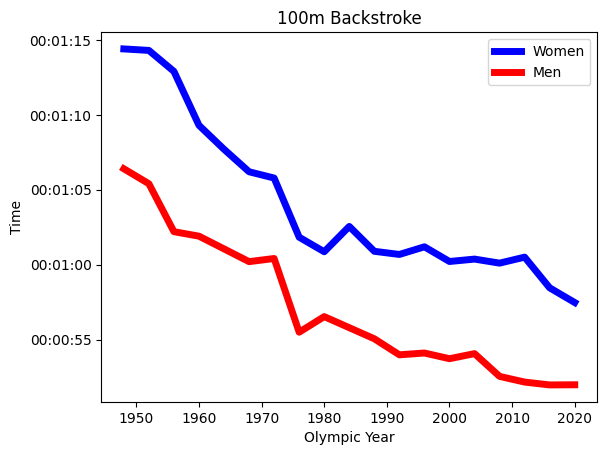

2024-12-31    56.529485
Freq: 4A-DEC, Name: Women, dtype: float64
2024-12-31    51.487692
Freq: 4A-DEC, Name: Men, dtype: float64
2024-12-31    235.682684
Freq: 4A-DEC, Name: Women, dtype: float64
2024-12-31    222.815966
Freq: 4A-DEC, Name: Men, dtype: float64


Text(0.5, 1.0, '400m Freestyle')

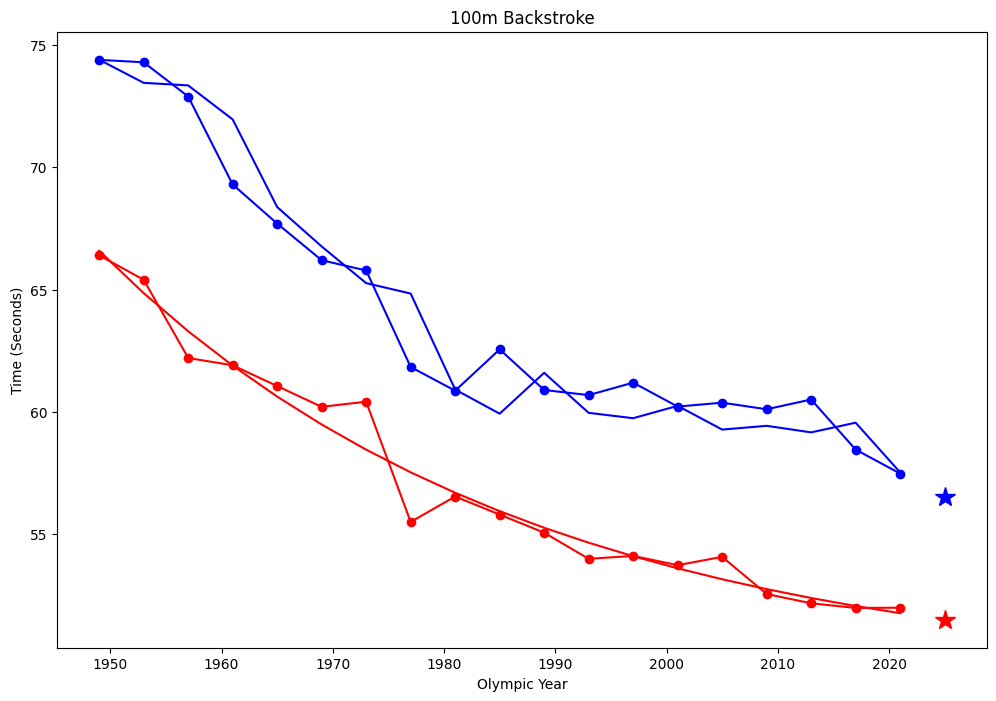

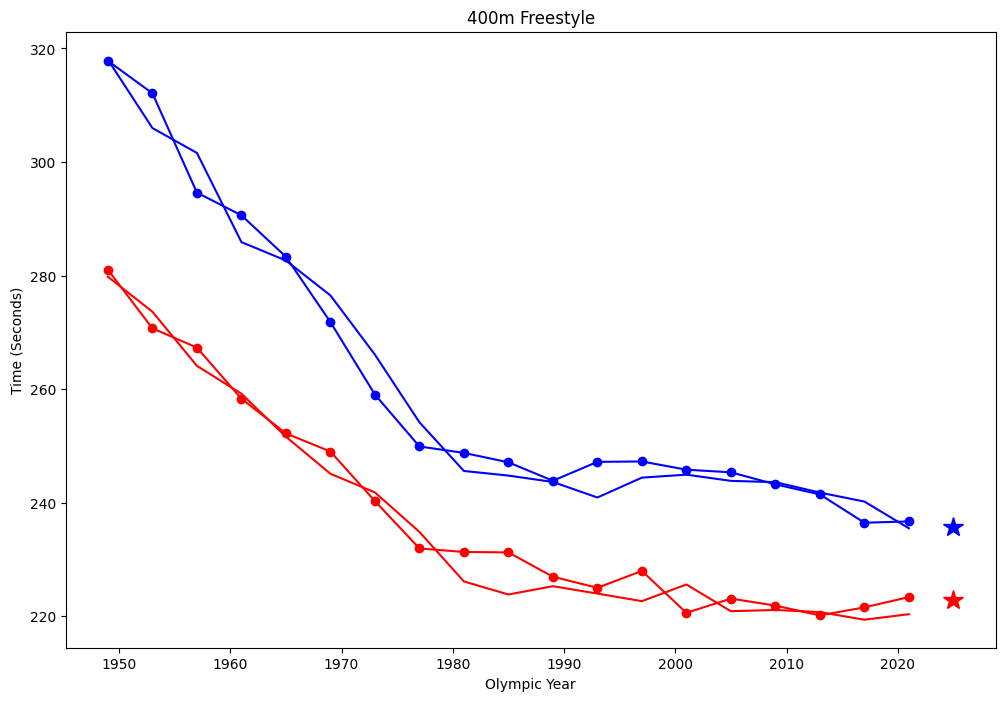

In [ ]:
# -*- coding: utf-8 -*-
#import the necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from datetime import datetime

#%%
#import the data set
data = pd.read_csv('swimming.csv')

#drop NA values and reset the index
data = data.dropna()
data = data[data['Rank'] != 0]
data = data.reset_index(drop = True)

#format the results string to get all times in the same format
for i in range(len(data)):
    item = data.iloc[i,8]
    if item.count('.') == 0:
        data.iloc[i,8] = item+'.00'

for i in range(len(data)):
    item = data.iloc[i,8].split('.')[0] + '.' + data.iloc[i,8].split('.')[1]
    if item.count(':')==0:
        data.iloc[i,8]='00:00:'+item
    elif item.count(':')==1:
        data.iloc[i,8]='00:'+item
    elif item.count(':')==2:
        data.iloc[i,8]=item

#remove rows not formatted correctly
data = data[~data['Results'].str.contains('est')]

#create the date time columns
data['Date_Time'] = pd.to_datetime(data['Results'], format='%H:%M:%S.%f')
data['Time'] = data['Date_Time'].dt.time


for i in range(len(data)):
    data.iloc[i,11] = data.iloc[i,11].minute * 60 + data.iloc[i,11].second

data['Time'] = data['Time'].astype(str)
data['Final_Time'] = [None] * len(data)

#convert all of the times into seconds and milliseconds
for i in range(len(data)):
    if data.iloc[i,1] == 2020:
        ms = data.iloc[i,8].split('.')[1]
        ms = float(ms)
        ms = ms/100
        ms = str(ms)
        ms = ms.split('.')[1]
        data.iloc[i,12] = data.iloc[i,11] + '.' + ms
    else:
        string = data.iloc[i,8].split('.')[1]
        if len(string) == 3:
            ms = float(string)
            ms = ms/1000
            ms = str(ms)
            ms = ms.split('.')[1]
            data.iloc[i,12] = data.iloc[i,11] + '.' + ms
        if len(string) == 6:
            ms = float(string)
            ms = ms/1000000
            ms = str(ms)
            ms = ms.split('.')[1]
            data.iloc[i,12] = data.iloc[i,11] + '.' + ms

#change the final time to a numeric
data['Final_Time'] = data['Final_Time'].astype(float)

#get separate data frames for bronze, silver, gold finishers
gold = data[data['Rank'] == 1]
silver = data[data['Rank'] == 2]
bronze = data[data['Rank'] == 3]

#%%
#focus on one event: 100m backstroke
#format to start from the year 1948
#women
w100bk = gold[(gold["Gender"] == 'Women') & (gold['Distance (in meters)'] == '100m') & (gold['Stroke'] == 'Backstroke')]
w100bk = w100bk.sort_values(by = 'Year')
w100bk = w100bk[['Year', 'Date_Time', 'Final_Time']]
w100bk = w100bk.drop(3603) #drop a duplicate time
w100bk = w100bk.reset_index(drop = True)
w100bk = w100bk.iloc[4:23]

#men
m100bk = gold[(gold['Gender'] == 'Men') & (gold['Distance (in meters)'] == '100m') & (gold['Stroke'] == 'Backstroke')]
m100bk = m100bk.sort_values(by = 'Year')
m100bk = m100bk[['Year', 'Date_Time', 'Final_Time']]
m100bk = m100bk.reset_index(drop = True)

#add missing year as average of surrounding years
newrow = {'Year': 1964, 'Date_Time': pd.to_datetime('00:01:01.05', format='%H:%M:%S.%f'), 'Final_Time': 61.05}
m100bk.loc[len(m100bk)] = newrow #add to the end of the dataframe
m100bk = m100bk.sort_values(by = 'Year')
m100bk = m100bk.reset_index(drop = True)
m100bk = m100bk.iloc[5:24]


#%%
#plot the data to look at the time series
year = m100bk['Year'].tolist()
wtime = w100bk['Date_Time'].tolist()
mtime = m100bk['Date_Time'].tolist()
plt.plot(year, wtime, color = 'blue', linewidth = 5, label = 'Women')
plt.plot(year, mtime, color = 'red', linewidth = 5, label = 'Men')
plt.xlabel('Olympic Year')
plt.ylabel('Time')
plt.legend(loc = 'upper right', ncol = 1)
plt.title('100m Backstroke')
plt.show()

#%% 100 backstroke graph
#create an exponential smoothing model for the series
for i in range(len(w100bk)):
    year = w100bk.iloc[i,0]
    date = datetime(year,12,31).date()
    w100bk.iloc[i,0] = date

for i in range(len(m100bk)):
    year = m100bk.iloc[i,0]
    date = datetime(year,12,31).date()
    m100bk.iloc[i,0] = date

w100bk = w100bk.drop('Date_Time', axis = 1)
w100bk['Year'] = pd.to_datetime(w100bk['Year'])
w100bk = w100bk.set_index('Year')

m100bk = m100bk.drop('Date_Time', axis = 1)
m100bk['Year'] = pd.to_datetime(m100bk['Year'])
m100bk = m100bk.set_index('Year')

#womens result
model_w = ExponentialSmoothing(w100bk['Final_Time'], trend='add', seasonal=None, damped_trend = False, freq='4A')
w100bk_result = model_w.fit()
w100bk_result.summary()
fcastw = w100bk_result.forecast(1).rename("Women")
print(fcastw)

#mens result
model_m = ExponentialSmoothing(m100bk['Final_Time'], trend='add', seasonal=None, damped_trend = True, freq='4A')
m100bk_result = model_m.fit()
m100bk_result.summary()
fcastm = m100bk_result.forecast(1).rename("Men")
print(fcastm)

#create a graph of the forecasted times
plt.figure(figsize=(12, 8))
plt.plot(w100bk, marker="o", color="blue")
plt.plot(m100bk, marker="o", color="red")
plt.plot(w100bk_result.fittedvalues, color="blue")
(line1,) = plt.plot(fcastw, marker="*", color="blue", ms = 15)
plt.plot(m100bk_result.fittedvalues, color="red")
(line2,) = plt.plot(fcastm, marker="*", color="red", ms = 15)
#plt.legend([line1, line2], [fcastw.name, fcastm.name])
plt.xlabel('Olympic Year')
plt.ylabel('Time (Seconds)')
plt.title('100m Backstroke')

#%% follow the same process for the 400 free event to show the impact of covid
w400free = gold[(gold["Gender"] == 'Women') & (gold['Distance (in meters)'] == '400m') & (gold['Stroke'] == 'Freestyle')]
w400free = w400free.sort_values(by = 'Year')
w400free = w400free[['Year', 'Date_Time', 'Final_Time']]
w400free = w400free.reset_index(drop = True)
w400free = w400free.iloc[4:23]

#men
m400free = gold[(gold['Gender'] == 'Men') & (gold['Distance (in meters)'] == '400m') & (gold['Stroke'] == 'Freestyle')]
m400free = m400free.sort_values(by = 'Year')
m400free = m400free[['Year', 'Date_Time', 'Final_Time']]
m400free = m400free.reset_index(drop = True)
m400free = m400free.iloc[5:24]

#create an exponential smoothing model for the series
for i in range(len(w400free)):
    year = w400free.iloc[i,0]
    date = datetime(year,12,31).date()
    w400free.iloc[i,0] = date

for i in range(len(m400free)):
    year = m400free.iloc[i,0]
    date = datetime(year,12,31).date()
    m400free.iloc[i,0] = date

w400free = w400free.drop('Date_Time', axis = 1)
w400free['Year'] = pd.to_datetime(w400free['Year'])
w400free = w400free.set_index('Year')

m400free = m400free.drop('Date_Time', axis = 1)
m400free['Year'] = pd.to_datetime(m400free['Year'])
m400free = m400free.set_index('Year')

#womens result
model_w = ExponentialSmoothing(w400free['Final_Time'], trend='add', seasonal=None, damped_trend = True, freq='4A')
w400free_result = model_w.fit()
w400free_result.summary()
fcastw = w400free_result.forecast(1).rename("Women")
print(fcastw)

#mens result
model_m = ExponentialSmoothing(m400free['Final_Time'], trend='add', seasonal=None, damped_trend = False, freq='4A')
m400free_result = model_m.fit()
m400free_result.summary()
fcastm = m400free_result.forecast(1).rename("Men")
print(fcastm)

#create a graph of the forecasted times
plt.figure(figsize=(12, 8))
plt.plot(w400free, marker="o", color="blue")
plt.plot(m400free, marker="o", color="red")
plt.plot(w400free_result.fittedvalues, color="blue")
(line1,) = plt.plot(fcastw, marker="*", color="blue", ms = 15)
plt.plot(m400free_result.fittedvalues, color="red")
(line2,) = plt.plot(fcastm, marker="*", color="red", ms = 15)
#plt.legend([line1, line2], [fcastw.name, fcastm.name])
plt.xlabel('Olympic Year')
plt.ylabel('Time (Seconds)')
plt.title('400m Freestyle')

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 11 17:18:25 2024

@author: maddy
"""
#%% #READ IN THE DATA SETS AND FORMAT IT FOR THE 2024 PREDICTIONS (1)
#import the necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from datetime import datetime, timedelta

#import the data set
data = pd.read_csv('swimming.csv')

#drop NA values and reset the index
data = data.dropna()
data = data[data['Rank'] != 0]
data = data.reset_index(drop = True)

#format the results string to get all times in the same format
for i in range(len(data)):
    item = data.iloc[i,8]
    if item.count('.') == 0:
        data.iloc[i,8] = item+'.00'

for i in range(len(data)):
    item = data.iloc[i,8].split('.')[0] + '.' + data.iloc[i,8].split('.')[1]
    if item.count(':')==0:
        data.iloc[i,8]='00:00:'+item
    elif item.count(':')==1:
        data.iloc[i,8]='00:'+item
    elif item.count(':')==2:
        data.iloc[i,8]=item

#remove rows not formatted correctly
data = data[~data['Results'].str.contains('est')]

#create the date time columns
data['Date_Time'] = pd.to_datetime(data['Results'], format='%H:%M:%S.%f')
data['Time'] = data['Date_Time'].dt.time


for i in range(len(data)):
    data.iloc[i,11] = data.iloc[i,11].minute * 60 + data.iloc[i,11].second

data['Time'] = data['Time'].astype(str)
data['Final_Time'] = [None] * len(data)

#convert all of the times into seconds and milliseconds
for i in range(len(data)):
    if data.iloc[i,1] == 2020:
        ms = data.iloc[i,8].split('.')[1]
        ms = float(ms)
        ms = ms/100
        ms = str(ms)
        ms = ms.split('.')[1]
        data.iloc[i,12] = data.iloc[i,11] + '.' + ms
    else:
        string = data.iloc[i,8].split('.')[1]
        if len(string) == 3:
            ms = float(string)
            ms = ms/1000
            ms = str(ms)
            ms = ms.split('.')[1]
            data.iloc[i,12] = data.iloc[i,11] + '.' + ms
        if len(string) == 6:
            ms = float(string)
            ms = ms/1000000
            ms = str(ms)
            ms = ms.split('.')[1]
            data.iloc[i,12] = data.iloc[i,11] + '.' + ms

#change the final time to a numeric
data['Final_Time'] = data['Final_Time'].astype(float)

#get separate data frame for the gold medalists
gold = data[data['Rank'] == 1]

#create a function to format the data correctly
def event(gender, distance, stroke):
    name = gold[(gold["Gender"] == gender) & (gold['Distance (in meters)'] == distance) & (gold['Stroke'] == stroke)]
    name = name.sort_values(by = 'Year')
    name = name[['Year', 'Date_Time', 'Final_Time']]

    # Check for duplicates and remove them
    column_to_check = 'Final_Time'
    duplicates_mask = name[column_to_check].duplicated()
    if any(duplicates_mask):
        name = name[~duplicates_mask].copy() #keep first occurance and remove the rest

    name = name.reset_index(drop = True)
    name = name[name['Year'] >= 1948]
    return name

#create a function to execute the modeling (and one for damped model)
def model(race):
    #convert the year column to a date-time
    for i in range(len(race)):
        year = race.iloc[i,0]
        date = datetime(year,12,31).date()
        race.iloc[i,0] = date

    #format the data correctly for the model
    race = race.drop('Date_Time', axis = 1)
    race['Year'] = pd.to_datetime(race['Year'])
    race = race.set_index('Year')

    #execute the model
    model = ExponentialSmoothing(race['Final_Time'], trend='add', seasonal=None, damped_trend = False, freq='4A')
    results = model.fit()
    results.summary()
    fcast = results.forecast(1)

    return fcast

def model2(race):
    #convert the year column to a date-time
    for i in range(len(race)):
        year = race.iloc[i,0]
        date = datetime(year,12,31).date()
        race.iloc[i,0] = date

    #format the data correctly for the model
    race = race.drop('Date_Time', axis = 1)
    race['Year'] = pd.to_datetime(race['Year'])
    race = race.set_index('Year')

    #execute the model
    model = ExponentialSmoothing(race['Final_Time'], trend='add', seasonal=None, damped_trend = True, freq='4A')
    results = model.fit()
    results.summary()
    fcast = results.forecast(1)

    return fcast
#%% #FILL IN ALL THE MISSING VALUES FOR THE EVENTS (2,5,10,13)
#apply the data preparation function (events) to all events
#fix any other missing values or disc

m50free = event('Men', '50m', 'Freestyle') #9 *only introduced in 1988
w50free = event('Women', '50m', 'Freestyle') #9

m100free = event('Men','100m','Freestyle') #19
w100free = event('Women','100m','Freestyle') #18 (missing 1952)

#add missing row for women's 100 free
newrow = {'Year': 1952, 'Date_Time': pd.to_datetime('00:01:06.80', format='%H:%M:%S.%f'), 'Final_Time': 66.80}
w100free = w100free.reset_index(drop = True)
w100free.loc[len(w100free)] = newrow
w100free = w100free.sort_values(by = 'Year')
w100free = w100free.reset_index(drop = True)

m200free = event('Men','200m','Freestyle') #14
w200free = event('Women','200m','Freestyle') #14

m400free = event('Men','400m','Freestyle') #19
w400free = event('Women','400m','Freestyle') #19

m800free = event('Men','800m','Freestyle') #1
w800free = event('Women','800m','Freestyle') #14 *introduced in 1968

m1500free = event('Men','1500m','Freestyle') #19
w1500free = event('Women','1500m','Freestyle') #1

m100bk = event('Men','100m','Backstroke') #18 (missing 1964)
w100bk = event('Women','100m','Backstroke') #19

#add missing row for men's 100 back - the event was actually removed this year, so average time used
newrow = {'Year': 1964, 'Date_Time': pd.to_datetime('00:01:01.05', format='%H:%M:%S.%f'), 'Final_Time': 61.05}
m100bk = m100bk.reset_index(drop = True)
m100bk.loc[len(m100bk)] = newrow #add to the end of the dataframe
m100bk = m100bk.sort_values(by = 'Year')
m100bk = m100bk.reset_index(drop = True)

m200bk = event('Men','200m','Backstroke') #15 *returned in 1964
w200bk = event('Women','200m','Backstroke') #14 *added in 1968

m100br = event('Men','100m','Breaststroke') #13 (missing 1980)
w100br = event('Women','100m','Breaststroke') #13 (missing 2004)

#add missing row for men's and women's 100 breast
newrow = {'Year': 1980, 'Date_Time': pd.to_datetime('00:01:03.44', format='%H:%M:%S.%f'), 'Final_Time': 63.44}
m100br = m100br.reset_index(drop = True)
m100br.loc[len(m100br)] = newrow #add to the end of the dataframe
m100br = m100br.sort_values(by = 'Year')
m100br = m100br.reset_index(drop = True)

newrow = {'Year': 2004, 'Date_Time': pd.to_datetime('00:01:06.64', format='%H:%M:%S.%f'), 'Final_Time': 66.64}
w100br = w100br.reset_index(drop = True)
w100br.loc[len(w100br)] = newrow #add to the end of the dataframe
w100br = w100br.sort_values(by = 'Year')
w100br = w100br.reset_index(drop = True)

m200br = event('Men','200m','Breaststroke') #17 (missing 1984 and 2004)
w200br = event('Women','200m','Breaststroke') #18 (missing 2016)

#add missing rows for men's and women's 200 breast
newrow = {'Year': 2016, 'Date_Time': pd.to_datetime('00:02:20.30', format='%H:%M:%S.%f'), 'Final_Time': 140.30}
w200br = w200br.reset_index(drop = True)
w200br.loc[len(w200br)] = newrow #add to the end of the dataframe
w200br = w200br.sort_values(by = 'Year')
w200br = w200br.reset_index(drop = True)

newrow = {'Year': 1984, 'Date_Time': pd.to_datetime('00:02:13.34', format='%H:%M:%S.%f'), 'Final_Time': 133.34}
m200br = m200br.reset_index(drop = True)
m200br.loc[len(m200br)] = newrow #add to the end of the dataframe
m200br = m200br.sort_values(by = 'Year')
m200br = m200br.reset_index(drop = True)

newrow = {'Year': 2004, 'Date_Time': pd.to_datetime('00:02:09.44', format='%H:%M:%S.%f'), 'Final_Time': 129.44}
m200br = m200br.reset_index(drop = True)
m200br.loc[len(m200br)] = newrow #add to the end of the dataframe
m200br = m200br.sort_values(by = 'Year')
m200br = m200br.reset_index(drop = True)

m100fly = event('Men','100m','Butterfly') #14
w100fly = event('Women','100m','Butterfly') #16 (missing 2016)

#add missing row for women's 100 fly
newrow = {'Year': 2016, 'Date_Time': pd.to_datetime('00:00:55.48', format='%H:%M:%S.%f'), 'Final_Time': 55.48}
w100fly = w100fly.reset_index(drop = True)
w100fly.loc[len(w100fly)] = newrow #add to the end of the dataframe
w100fly = w100fly.sort_values(by = 'Year')
w100fly = w100fly.reset_index(drop = True)

m200fly = event('Men','200m','Butterfly') #17 *introduced in 1956
w200fly = event('Women','200m','Butterfly') #14 *introduced in 1968

m200im = event('Men','200m','Individual medley') #12 (68,72 --> 84) cut at 84
w200im = event('Women','200m','Individual medley') #12 (large gap)

#fix the large gaps for men's and women's 200IM
m200im = m200im[m200im['Year'] > 1972]
w200im = w200im[w200im['Year'] > 1972]

m400im = event('Men','400m','Individual medley') #15
w400im = event('Women','400m','Individual medley') #14 (missing 2020)

#add missing row for women's 400IM
newrow = {'Year': 2020, 'Date_Time': pd.to_datetime('00:04:32.08', format='%H:%M:%S.%f'), 'Final_Time': 272.08}
w400im = w400im.reset_index(drop = True)
w400im.loc[len(w400im)] = newrow #add to the end of the dataframe
w400im = w400im.sort_values(by = 'Year')
w400im = w400im.reset_index(drop = True)

#%% #LISTS OF EVENTS TO HOLD FORECASTS (3,6,11,14)
#create a list of all the events and compile their forecasts
all_events = [m50free, w50free, m100free, w100free, m200free, w200free,
                    m400free, w400free, w800free, m1500free, m100bk, w100bk,
                    m200bk, w200bk, m100br, w100br, m200br, w200br, m100fly,
                    w100fly, m200fly, w200fly, m200im, w200im, m400im, w400im]

all_events2 = [m50free, w50free, m100free, w100free, m200free, w200free,
                    m400free, w400free, w800free, m1500free, m100bk, w100bk,
                    m200bk, w200bk, m100br, w100br, m200br, w200br, m100fly,
                    w100fly, m200fly, w200fly, m200im, w200im, m400im, w400im]

event_names = ['men 50free', 'women 50free', 'men 100free', 'women 100free', 'men 200free', 'women 200free',
                    'men 400free', 'women 400free', 'women 800free', 'men 1500free', 'men 100bk', 'women 100bk',
                    'men 200bk', 'women 200bk', 'men 100br', 'women 100br', 'men 200br', 'women 200br', 'men 100fly',
                    'women 100fly', 'men 200fly', 'women 200fly', 'men 200im', 'women 200im', 'men 400im', 'women 400im']

#%% #NORMAL PREDICTIONS FOR 2024 (4)
predictions_2024 = []

for i in all_events:                  #rerun this to get both damped and not damped
    result = float(model(i))          #must switch the function and list name in between
    predictions_2024.append(result)

#%% #DAMPED PREDICTIONS FOR 2024 (7)
predictions_2024_damped = []

for i in all_events2:
    result_damped = float(model2(i))
    predictions_2024_damped.append(result_damped)

#%% #DATAFRAME OF ALL 2024 PREDICTIONS (8)
all_predictions = pd.DataFrame({'Event Name': event_names, 'Prediction (s)': predictions_2024, 'Damped Prediction (s)': predictions_2024_damped})

# Function to convert seconds to time
def convert_seconds_to_time(seconds):
    delta = timedelta(seconds=seconds)
    base_time = datetime(1, 1, 1, 0, 0, 0)
    result_time = base_time + delta
    return result_time.time()

# Apply the function to the 'seconds_column' and create a new column
all_predictions['Prediction Time'] = all_predictions['Prediction (s)'].apply(convert_seconds_to_time)
all_predictions['Damped Prediction Time'] = all_predictions['Damped Prediction (s)'].apply(convert_seconds_to_time)

#add world record column to all_predictions
WR = [20.91, 23.61, 46.86, 51.71, 102, 112.85, 220.07, 235.38, 484.79, 871.02, 51.60, 57.33, 111.92, 123.14, 56.88, 64.13, 125.48, 137.55, 49.45, 55.48, 110.34, 121.81, 114, 126.12, 242.5, 265.87]
all_predictions['World Record'] = WR

#create a column that says yes or no if the record was broken
broken = []
broken_damped = []
for i in range(len(all_predictions)):
    if all_predictions['World Record'][i] < all_predictions['Prediction (s)'][i]:
        newrecord = 'No'
        broken.append(newrecord)
    else:
        newrecord = 'Yes'
        broken.append(newrecord)

for i in range(len(all_predictions)):
    if all_predictions['World Record'][i] < all_predictions['Damped Prediction (s)'][i]:
        newrecord = 'No'
        broken_damped.append(newrecord)
    else:
        newrecord = 'Yes'
        broken_damped.append(newrecord)

all_predictions['Record Broken?'] = broken
all_predictions['Record Broken? (Damped)'] = broken_damped

#%% #UPDATE EVENT FUNCTION TO GET THE 2020 PREDICTIONS (9)
def event(gender, distance, stroke):
    name = gold[(gold["Gender"] == gender) & (gold['Distance (in meters)'] == distance) & (gold['Stroke'] == stroke)]
    name = name.sort_values(by = 'Year')
    name = name[['Year', 'Date_Time', 'Final_Time']]

    # Check for duplicates and remove them
    column_to_check = 'Final_Time'
    duplicates_mask = name[column_to_check].duplicated()
    if any(duplicates_mask):
        name = name[~duplicates_mask].copy() #keep first occurance and remove the rest

    name = name.reset_index(drop = True)
    name = name[name['Year'] >= 1948]
    name = name[name['Year'] <= 2016]
    return name

#%% #NORMAL PREDICTIONS FOR 2020 (12)

predictions_2020 = []

for i in all_events:                  #rerun this to get both damped and not damped
    result = float(model(i))          #must switch the function and list name in between
    predictions_2020.append(result)

predictions_2020_damped = []

#%% #DAMPED PREDICTIONS FOR 2020 (15)
for i in all_events2:
    result_damped = float(model2(i))
    predictions_2020_damped.append(result_damped)

all_predictions_2020 = pd.DataFrame({'Event Name': event_names, 'Prediction (s)': predictions_2020, 'Damped Prediction (s)': predictions_2020_damped})

#add the winning times from 2020 to the data frame
winners_2020 = gold[(gold['Year'] == 2020)]

winning_times_2020 = [21.07, 23.81, 47.02, 51.96, 104.22, 113.5, 223.36, 236.69, 492.57, 879.65, 51.98, 57.47, 113.27, 124.68, 57.37, 64.95, 126.38, 138.95, 49.45, 55.59, 111.25, 123.86, 115, 128.52, 249.42, 272.08]
all_predictions_2020['Winners 2020'] = winning_times_2020

mae_2020 = []
mae_damped_2020 = []

for i in range(len(all_predictions_2020)):
    error = abs(all_predictions_2020['Prediction (s)'][i] - all_predictions_2020['Winners 2020'][i])
    mae_2020.append(error)

for i in range(len(all_predictions_2020)):
    error = abs(all_predictions_2020['Damped Prediction (s)'][i] - all_predictions_2020['Winners 2020'][i])
    mae_damped_2020.append(error)

all_predictions_2020['MAE'] = mae_2020
all_predictions_2020['Damped MAE'] = mae_damped_2020

#compare overall MAE of damped vs not damped predictions
mae_2020_sum = sum(mae_2020)
print('Overall MAE =', mae_2020_sum)

mae_2020_sum_damped = sum(mae_damped_2020) #more accurate on shorter events
print('Overall DAMPED MAE =', mae_2020_sum_damped)

#better model
which_model = []
for i in range(len(all_predictions_2020)):
    if all_predictions_2020['MAE'][i] < all_predictions_2020['Damped MAE'][i]:
        which = 'Regular'
        which_model.append(which)
    else:
        which = 'Damped'
        which_model.append(which)

all_predictions_2020['Best Model'] = which_model

#%% #MERGE THE TWO DATAFRAMES TOGETHER FOR FULL INFORMATION (16)
#merge predictions and 2020 details together!
final_results = pd.merge(all_predictions, all_predictions_2020, on = 'Event Name')

#final predictions exported
#final_results.to_csv('final_results_allcolumns.csv', index=False)

<ipython-input-4-a3973191f962>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date_Time'] = pd.to_datetime(data['Results'], format='%H:%M:%S.%f')
<ipython-input-4-a3973191f962>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Time'] = data['Date_Time'].dt.time


TypeError: 'datetime.date' object cannot be interpreted as an integer